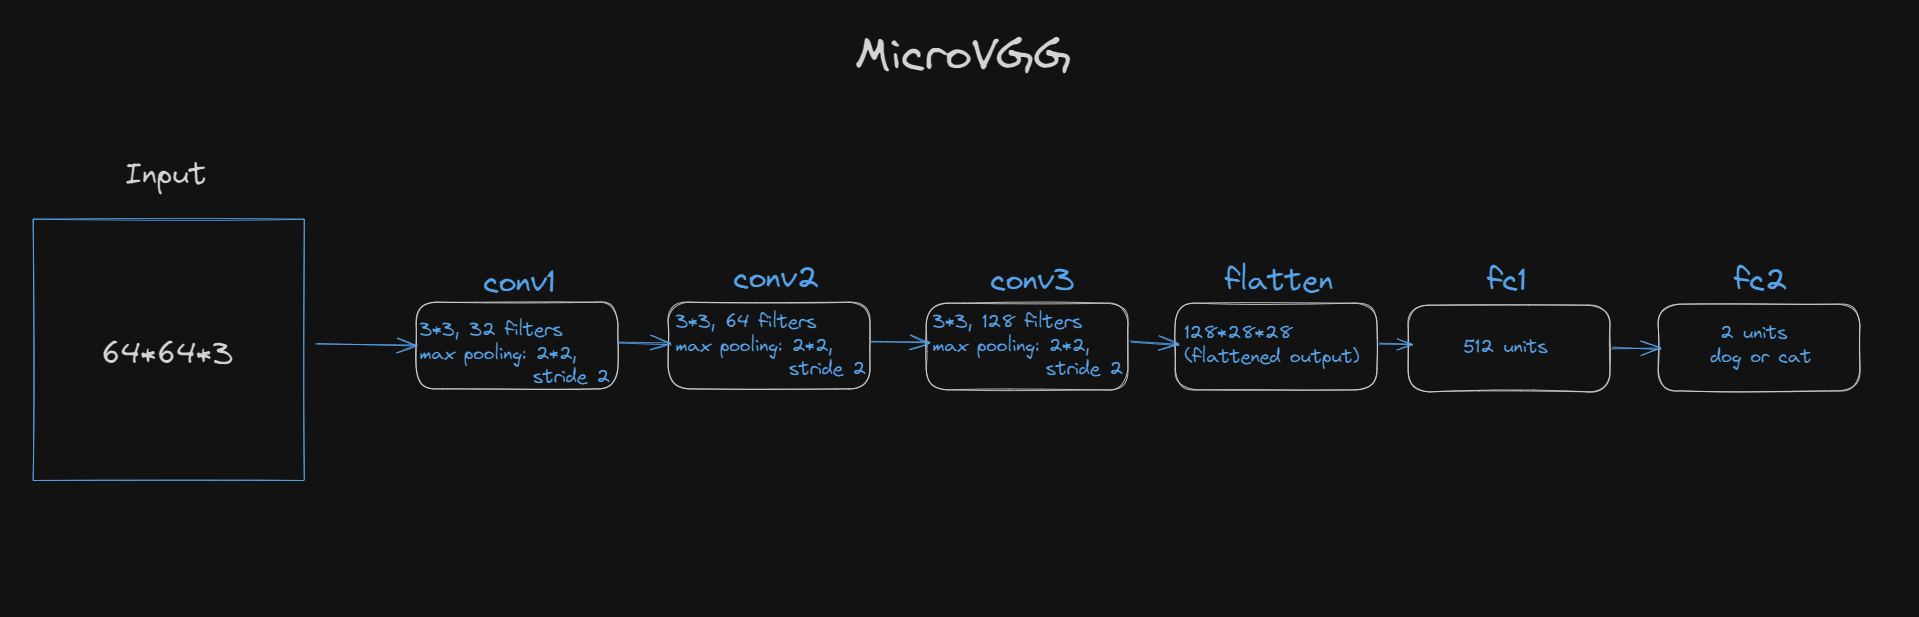

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchmetrics import Accuracy

# MICRO VGG Architecture

In [2]:
class MicroVGG(nn.Module):
    def __init__(self):
        super(MicroVGG, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 128*8*8)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = MicroVGG().to(device)

In [5]:
model

MicroVGG(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

accuracy = Accuracy(task='multiclass', num_classes=2).to(device)

In [7]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [8]:
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 47935478.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:
target_classes = [3, 5]
indices = [i for i, label in enumerate(cifar10.targets) if label in target_classes]

In [10]:
dogsncats = Subset(cifar10, indices)
for i, idx in enumerate(indices):
    dogsncats.dataset.targets[idx] = target_classes.index(cifar10.targets[idx])

In [11]:
train_loader = DataLoader(dogsncats, batch_size=32, shuffle=True)

In [12]:
epochs = 10

for epoch in range(epochs):
    running_loss = 0
    running_accuracy = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        running_accuracy += accuracy(preds, labels).item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
        
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch [1/10], Loss: 0.6605, Accuracy: 0.6016
Epoch [2/10], Loss: 0.6024, Accuracy: 0.6758
Epoch [3/10], Loss: 0.5620, Accuracy: 0.7043
Epoch [4/10], Loss: 0.5286, Accuracy: 0.7335
Epoch [5/10], Loss: 0.4933, Accuracy: 0.7573
Epoch [6/10], Loss: 0.4513, Accuracy: 0.7813
Epoch [7/10], Loss: 0.4017, Accuracy: 0.8138
Epoch [8/10], Loss: 0.3388, Accuracy: 0.8488
Epoch [9/10], Loss: 0.2668, Accuracy: 0.8865
Epoch [10/10], Loss: 0.1939, Accuracy: 0.9207
